In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
# import string
# from string import punctuation
# from itertools import chain

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, f_classif
from sklearn.utils import shuffle

! pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
# from sklearn import svm

# nltk.download('stopwords')
# from nltk.stem import WordNetLemmatizer
# from nltk import ngrams

import re
import string

! pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


! pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

! pip install tensorflow

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
import io
import json

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading dataset and exploration

In [2]:
df = pd.read_csv("csv's/TrainingDataset.csv")

In [3]:
df.columns

Index(['userName', 'verified', 'itemName', 'description', 'image', 'brand',
       'feature', 'category', 'price', 'rating', 'reviewTime', 'summary',
       'reviewText', 'vote'],
      dtype='object')

In [4]:
df.shape

(551159, 14)

In [5]:
print(df.isnull().sum())

userName         133
verified           0
itemName           1
description        8
image              0
brand           3872
feature            0
category           0
price          74334
rating             0
reviewTime         0
summary          243
reviewText       428
vote               0
dtype: int64


In [6]:
df.head(2)

,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote
0,Amazon Customer,True,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...","[""Made from deliciously decadent ingredients, ...",['https://images-na.ssl-images-amazon.com/imag...,Toblerone,[],Prime_Pantry,$1.63,5.0,2018-01-01,Five Stars,super smooth and yummy with crunchy bits,0
1,Carla,True,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags","['Prince of Peace Enterprises, Inc., founded i...",['https://images-na.ssl-images-amazon.com/imag...,Prince Of Peace,[],Grocery_and_Gourmet_Food,$6.40,5.0,2018-01-01,Five Stars,Perfect for kombucha,0


In [7]:
pos = df[df['rating']>3]
neg = df[df['rating']<3]
print(pos.shape, neg.shape)

(453086, 14) (57434, 14)


# Largely imbalanced
May have to oversample/undersample

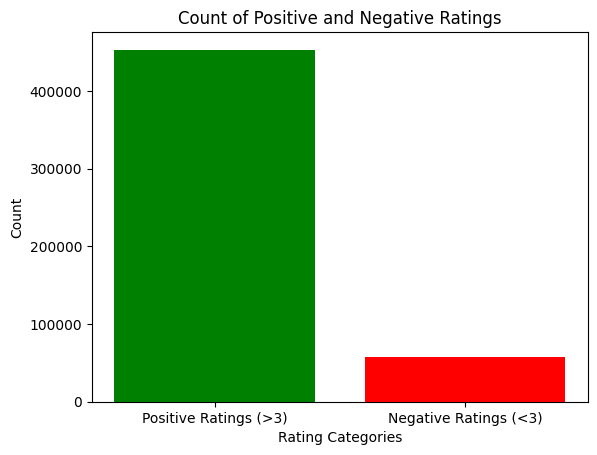

In [8]:
counts = [pos.shape[0], neg.shape[0]]

# Create a bar chart
plt.bar(['Positive Ratings (>3)', 'Negative Ratings (<3)'], counts, color=['green', 'red'])
plt.title('Count of Positive and Negative Ratings')
plt.ylabel('Count')
plt.xlabel('Rating Categories')
plt.show()

## Preprocessing:
- Done via a sentiment map
- resulting column added to original dataframe

In [9]:
sentiment_map = {1:0, 2:0, 4:1, 5:1}

temp = df[df['rating'] != 3]
y = temp['rating'].map(sentiment_map)

df.loc[:, 'sentiment'] = y

In [10]:
df.head(2)

,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote,sentiment
0,Amazon Customer,True,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...","[""Made from deliciously decadent ingredients, ...",['https://images-na.ssl-images-amazon.com/imag...,Toblerone,[],Prime_Pantry,$1.63,5.0,2018-01-01,Five Stars,super smooth and yummy with crunchy bits,0,1.0
1,Carla,True,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags","['Prince of Peace Enterprises, Inc., founded i...",['https://images-na.ssl-images-amazon.com/imag...,Prince Of Peace,[],Grocery_and_Gourmet_Food,$6.40,5.0,2018-01-01,Five Stars,Perfect for kombucha,0,1.0


## Preparing dataframe for preprocessing

In [11]:
reviews_to_clean = pd.DataFrame()
reviews_to_clean = df['reviewText']

In [12]:
print(reviews_to_clean.head(3))

0             super smooth and yummy with crunchy bits
1                                 Perfect for kombucha
2    Finally a harness that fits my puppy. I really...
Name: reviewText, dtype: object


In [13]:
print(type(reviews_to_clean))

<class 'pandas.core.series.Series'>


In [14]:
print(reviews_to_clean.shape)

(551159,)


In [15]:
stop_words = stopwords.words('english')

## Cleaning HTML aspects
- includes tags and https:// 

In [16]:
def clean_html(text):
    # Remove URLs
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    return text

## Creating tokens

In [17]:
def tokenize_df(text):
    if isinstance(text, str):  # If the input is a string
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token.isalpha()]  # Keep only alphabetic tokens
        return tokens
    elif isinstance(text, (int, float)):  # If the input is an integer or float
        return text  # Return the number as is
    else:
        return []

## Removing stopwords

In [18]:
def remove_stopwords(tokens):
    stop_words = (stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

## Lemmatization:
- Spelling or semantics of words may have been affected via tokenisation or punctuation removal. This was done to try to preserve value of those that may have been affected

In [19]:
# def lemmatize_text(tokens):
#     lemma = WordNetLemmatizer()
#     lemma_token = [lemma.lemmatize(word) for word in tokens]
#     return lemma_token

def lemmatize_text(tokens):
    if tokens is None:
        return []  # Return an empty list if tokens is None
    lemma = WordNetLemmatizer()
    lemma_tokens = [lemma.lemmatize(word) for word in tokens if word is not None]  # Check for None
    return lemma_tokens

## Cleaning text utilizing prior functions

In [20]:
def clean_text(text):
    if not isinstance(text, str):  # Check if the input is not a string
        return ''  # Return an empty string or handle it as needed
    text = clean_html(text)
    tokens = tokenize_df(text)
    tokens = [token.lower() for token in tokens]
    tokens = remove_stopwords(tokens)
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
    tokens = lemmatize_text(tokens)
    return ' '.join(tokens)

In [21]:
cleaned_reviews = reviews_to_clean.apply(clean_text)

## Convert all instances of float or integer data to string:
- This was done to avoid instances of float or integer.
- Chose not to drop the values since it may hold value in our analysis

In [22]:
cleaned_reviews.apply(lambda x: re.sub(r"\s+", " ", x).strip()if isinstance(x, str) else x)

0                            super smooth yummy crunchy bit
1                                          perfect kombucha
2         finally harness fit puppy really need harness ...
3         love bought micheals curiosity wanting try dif...
4         love pen love shape feel weight color highly r...
                                ...                        
551154                               cheap price weak chain
551155                                       great deck box
551156    putting weather station anticipate problem kee...
551157    nice quality grilling table put grilling stuff...
551158                       nice variety pack whole family
Name: reviewText, Length: 551159, dtype: object

## Dropping values:
- This was done to account for any rows that had no data. Avoids NaN representation for text_fit

In [23]:
cleaned_reviews = cleaned_reviews.fillna('').astype(str)

In [24]:
cleaned_reviews.to_csv('cleaned_reviews.csv', index=False)

In [25]:
print(cleaned_reviews.isnull().sum())

0


In [26]:
cleaned_reviews.head(3)

0                       super smooth yummy crunchy bit
1                                     perfect kombucha
2    finally harness fit puppy really need harness ...
Name: reviewText, dtype: object

In [27]:
cleaned_reviews.shape

(551159,)

In [28]:
def print_cloud(data):
    text = " ".join(review for review in data)
    print ("There are {} words in the combination of all reviews.".format(len(text)))
    stopwords_set = set(stopwords.words('english'))
    wordcloud = WordCloud(stopwords=stopwords_set, background_color="white").generate(text)
    return wordcloud

## Visualisation
- Small visualisation to check if cleaning went as expected

There are 54532759 words in the combination of all reviews.


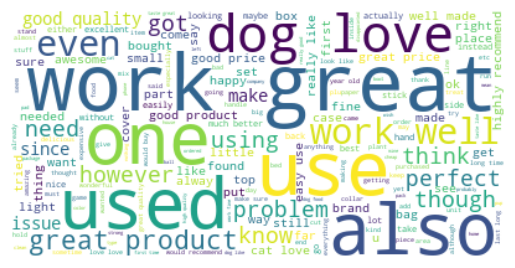

In [29]:
wordcloud = print_cloud(cleaned_reviews)
fig = plt.figure(1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
X = cleaned_reviews
print(type(X))
print(X.shape)

<class 'pandas.core.series.Series'>
(551159,)


In [31]:
y = df['sentiment']
print(type(y))
print(y.shape)
print(y.isnull().sum()) 

<class 'pandas.core.series.Series'>
(551159,)
40639


## Dropping NaN 
- Dropped those rows with NaN representations in sentiments based on the assumption their rating was a 3/5. Justified since the data loss is negligible when compared to that which remains

In [32]:
y = y.dropna()
X = X[y.index] 
print(X.shape)
print(y.shape)

(510520,)
(510520,)


In [33]:
def text_fit(X, y, model, clf_model, coef_show=1,):
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    recall = recall_score(y_test,y_pred)
    print ('Model Recall: {}'.format(recall))
    print ('Model F1-Score: {}'.format(f1_score(y_test,y_pred)))
    if coef_show == 1: 
        w = model.get_feature_names_out()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])

        top_positive = coeff_df.head(10)
        top_negative = coeff_df.tail(10)

        print('')
        print('-Top 10 positive-')
        print(coeff_df.head(10).to_string(index=False))
        print('')
        print('-Top 10 negative-')        
        print(coeff_df.tail(10).to_string(index=False))


        plt.figure(figsize=(12, 6))

        # Positive words
        plt.subplot(1, 2, 1)
        sns.barplot(x='Coefficient', y='Word', data=top_positive, palette='viridis')
        plt.title('Top 10 Positive Words')
        plt.xlabel('Coefficient')
        plt.ylabel('Words')

        # Negative words
        plt.subplot(1, 2, 2)
        sns.barplot(x='Coefficient', y='Word', data=top_negative, palette='viridis')
        plt.title('Top 10 Negative Words')
        plt.xlabel('Coefficient')
        plt.ylabel('Words')

        plt.tight_layout()
        plt.show()

## Interpretation
- A recall of approximately 0.99 indicates that the model is very effective at identifying positive sentiments in the reviews.
- The output lists the top 20 words (or n-grams) that are most strongly associated with positive sentiment, along with their coefficients.
- The words listed here are the strongest indicators of positive sentiment in the reviews. The coefficients represent the weight of each word in the logistic regression model.

# features: 2268711
# train records: 382890
# test records: 127630
Model Recall: 0.9913458563535912
Model F1-Score: 0.9629076296945032

-Top 10 positive-
     Word  Coefficient
    great    20.230047
     love    20.214720
  perfect    13.603012
excellent    10.695125
     best    10.560789
delicious    10.050529
     nice     9.999580
  amazing     9.881636
perfectly     9.705045
     easy     8.707396

-Top 10 negative-
         Word  Coefficient
        awful    -8.462631
         poor    -8.950597
     horrible    -9.147159
     terrible    -9.493881
    returning    -9.574196
       return    -9.584628
      useless    -9.918947
        worst   -10.074581
disappointing   -11.252022
 disappointed   -12.616024


C:\Users\kaila\AppData\Local\Temp\ipykernel_22492\3739080139.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Word', data=top_positive, palette='viridis')
C:\Users\kaila\AppData\Local\Temp\ipykernel_22492\3739080139.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Word', data=top_negative, palette='viridis')


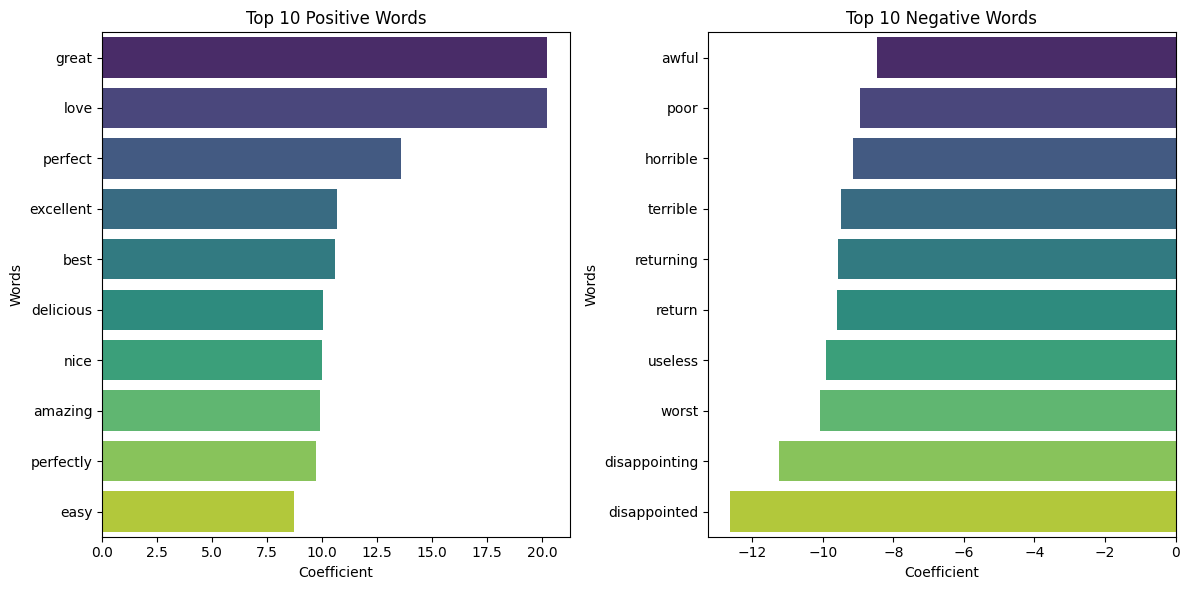

In [34]:
top_positive = pd.DataFrame() 
top_negative = pd.DataFrame()

tfidf_n = TfidfVectorizer(ngram_range=(1,2), stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

In [35]:
y.head(3)

0    1.0
1    1.0
2    1.0
Name: sentiment, dtype: float64

In [36]:
reviews = []
sentiments = []

reviews = X
sentiments = y
sentiments = np.array(list(map(lambda x: 1 if x==1 else 0, sentiments)))

In [37]:
print(sentiments)

[1 1 1 ... 1 1 1]


In [38]:
len(reviews), len(sentiments)

(510520, 510520)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(reviews, sentiments, 
                                                test_size=0.20, random_state=42)

In [40]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [41]:
tokenizer_json = word_tokenizer.to_json()
with io.open('embedded.json', 'w', encoding = 'utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [42]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

60297

In [43]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [44]:
smote = SMOTE(sampling_strategy='minority', random_state=42)

In [45]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_resampled, y_resampled = smote.fit_resample(X_train_flat, y_train)

In [46]:
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test_flat, y_test)

In [47]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [48]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [49]:
embedding_matrix.shape

(60297, 100)

In [50]:
from keras.layers import LSTM

In [51]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [52]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', 
                    metrics=['acc'])

In [53]:
lstm_model_history = lstm_model.fit(X_resampled, y_resampled, batch_size=128, epochs=8, 
                                        verbose=1,validation_split=0.2)

Epoch 1/8
4532/4532 ━━━━━━━━━━━━━━━━━━━━ 497s 109ms/step - acc: 0.6286 - loss: 0.6514 - val_acc: 0.7012 - val_loss: 0.6014
Epoch 2/8
4532/4532 ━━━━━━━━━━━━━━━━━━━━ 496s 109ms/step - acc: 0.8593 - loss: 0.3229 - val_acc: 0.8908 - val_loss: 0.2592
Epoch 3/8
4532/4532 ━━━━━━━━━━━━━━━━━━━━ 494s 109ms/step - acc: 0.9034 - loss: 0.2337 - val_acc: 0.8834 - val_loss: 0.2653
Epoch 4/8
4532/4532 ━━━━━━━━━━━━━━━━━━━━ 494s 109ms/step - acc: 0.9157 - loss: 0.2057 - val_acc: 0.9056 - val_loss: 0.2299
Epoch 5/8
4532/4532 ━━━━━━━━━━━━━━━━━━━━ 495s 109ms/step - acc: 0.9246 - loss: 0.1874 - val_acc: 0.8877 - val_loss: 0.2695
Epoch 6/8
4532/4532 ━━━━━━━━━━━━━━━━━━━━ 498s 110ms/step - acc: 0.9305 - loss: 0.1742 - val_acc: 0.9104 - val_loss: 0.2137
Epoch 7/8
4532/4532 ━━━━━━━━━━━━━━━━━━━━ 547s 121ms/step - acc: 0.9363 - loss: 0.1619 - val_acc: 0.9203 - val_loss: 0.1959
Epoch 8/8
4532/4532 ━━━━━━━━━━━━━━━━━━━━ 532s 117ms/step - acc: 0.9411 - loss: 0.1508 - val_acc: 0.9244 - val_loss: 0.1882


In [54]:
y_pred = lstm_model.predict(X_test_resampled)

5660/5660 ━━━━━━━━━━━━━━━━━━━━ 91s 16ms/step


In [55]:
y_pred = np.round(y_pred * 1).astype(int)
y_pred = y_pred.flatten()
y_pred

array([0, 1, 1, ..., 0, 0, 0])

              precision    recall  f1-score   support

           0       0.94      0.89      0.91     90554
           1       0.90      0.94      0.92     90554

    accuracy                           0.92    181108
   macro avg       0.92      0.92      0.92    181108
weighted avg       0.92      0.92      0.92    181108

Confusion Matrix:
[[80726  9828]
 [ 5187 85367]]


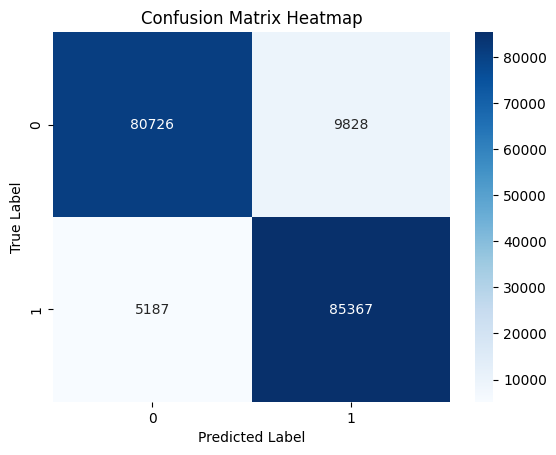

In [56]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_resampled, y_pred))

cm = confusion_matrix(y_test_resampled, y_pred)

print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [57]:
score = lstm_model.evaluate(X_test_resampled, y_test_resampled, verbose=1)

5660/5660 ━━━━━━━━━━━━━━━━━━━━ 100s 18ms/step - acc: 0.9165 - loss: 0.2146


In [58]:
lstm_model.save('lstm_model.keras')

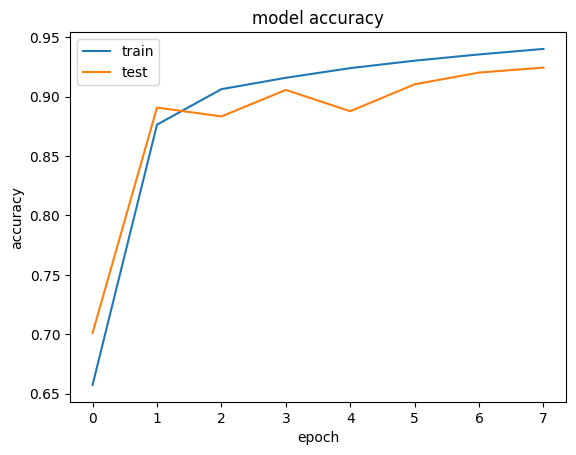

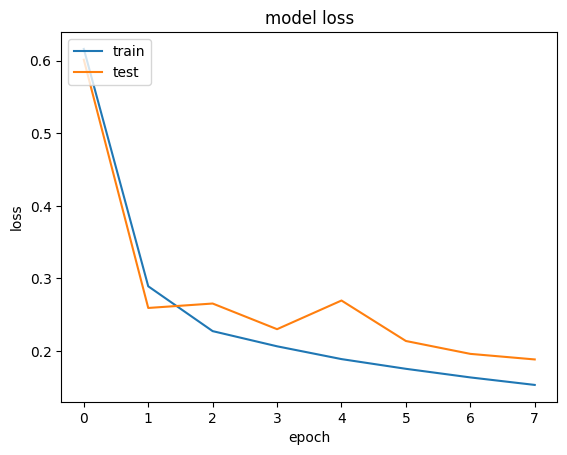

In [59]:
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()